# Supervised Algorithms For The Detection Of COVID-19 From Chest X-Ray Scan Images

### Import necessary libraries

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.extmath import density
from sklearn.neural_network import MLPClassifier
from imutils import paths
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import mahotas
from IPython.display import Image
from time import time
from pylab import imshow, gray, show
from os import path
import random
%matplotlib inline
print('Libraries successfully imported')

Libraries successfully imported


### Extract a 3D color histogram from the HSV colorspace to characterize the color distribution of the pixels in the images

In [2]:
def extract_color_histogram(image, bins=[8, 8, 8]):
#Extract using the supplied number of `bins` per channel,\
#then perform "in place" normalization in OpenCV, and return the flattened histogram as the feature vector
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([image], [0], None, [180], [0, 180])
    hist_s = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([image], [2], None, [256], [0, 256])
    hist_h = cv2.normalize(hist_h, hist_h)
    hist_s = cv2.normalize(hist_s, hist_s)
    hist_v = cv2.normalize(hist_v, hist_v)
    return np.concatenate([hist_h, hist_s, hist_v], axis=0).reshape(-1)

### Extract the Haralick Texture features using Mahotas, and return the feature vector

In [3]:
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the Haralick Texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

### Extract the Threshold Adjacency Statistics features using Mahotas, and return the feature vector

In [4]:
def fd_tas(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the Threshold Adjacency Statistics feature vector
    value = mahotas.features.tas(gray) 
    return value

### Specify the directory for the CT scan images, and initialize the matrices

In [5]:
# grab the list of images that we'll be describing
print("[INFO] Loading images...")
imagePaths = list(paths.list_images("Images-processed/"))
histogram = []
hara = []
tas = []
labels = []
features = []

[INFO] Loading images...


### Benchmark function

In [6]:
results = []
def benchmark(clf, name):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    print()

    score = accuracy_score(y_test, pred)
    print("Train Accuracy: %0.3f" % accuracy_score(y_train, clf.predict(X_train)))
    print("Test Accuracy: %0.3f" % score)

    print()

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))
    
    print()
    print("classification report:")
    print(classification_report(y_test, pred))

    print("confusion matrix:")
    print(confusion_matrix(y_test, pred))
    
    plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, labels=['NON_COVID', 'COVID-19']) 
    plt.show()
    
    #plot_precision_recall_curve(clf, X_test, y_test)
    #plt.show()
    
    print()
    clf_descr = name
    return clf_descr, score, train_time, test_time

### Loop over the input images:
#### 1) load the image and extract the class label (assuming that our path is in the format: /path/to/dataset/{class}.{image_num}.jpg
#### 2) extract the Color Histogram, the Haralick Texture, and Threshold Adjacency Statistics features
#### 3) update the matricies respectively

In [7]:
start_time = time()
for (i, imagePath) in enumerate(imagePaths):

	image = cv2.imread(imagePath)
	label = imagePath.split(os.path.sep)[-1].split(".")[0]

	haralick = fd_haralick(image)
	tass = fd_tas(image)
	hist = extract_color_histogram(image)
    
	histogram.append(hist)
	tas.append(tass)
	hara.append(haralick)
	labels.append(label)
    
	if i > 0 and i % 100 == 0:    # show an update every 100 images
		print("[INFO] Processed {}/{}".format(i, len(imagePaths)))
print("[INFO] Processed {}/{}".format(i+1, len(imagePaths)))
print("--- %s seconds ---" % (time() - start_time))

[INFO] Processed 100/1227
[INFO] Processed 200/1227
[INFO] Processed 300/1227
[INFO] Processed 400/1227
[INFO] Processed 500/1227
[INFO] Processed 600/1227
[INFO] Processed 700/1227
[INFO] Processed 800/1227
[INFO] Processed 900/1227
[INFO] Processed 1000/1227
[INFO] Processed 1100/1227
[INFO] Processed 1200/1227
[INFO] Processed 1227/1227
--- 451.5519459247589 seconds ---


### Show some information on the memory consumed each matrix

In [8]:
histogram = np.array(histogram)
labels = np.array(labels)
hara = np.array(hara)
tas = np.array(tas)
features = np.concatenate((hara, tas), axis=1)
features = np.concatenate((features, histogram), axis=1)


print("[INFO] histogram matrix: {} {:.2f}MB".format(
	histogram.shape, histogram.nbytes / (1024 * 1000.0)))
print("[INFO] haralick matrix: {} {:.2f}MB".format(
    hara.shape, hara.nbytes / (1024 * 1000.0)))
print("[INFO] TAS matrix: {} {:.2f}MB".format(
    tas.shape, tas.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {} {:.2f}MB".format(
    features.shape, features.nbytes / (1024 * 1000.0)))

[INFO] histogram matrix: (1227, 692) 3.32MB
[INFO] haralick matrix: (1227, 13) 0.12MB
[INFO] TAS matrix: (1227, 54) 0.52MB
[INFO] features matrix: (1227, 759) 7.28MB


### Split partition the data into training and testing splits, using 80% of the data for training and 20% for testing, with a random state of 10

In [9]:
(trainHara, testHara, trainHaraL, testHaraL) = train_test_split(hara, labels, test_size=0.20, random_state=10)
(trainTas, testTas, trainTasL, testTasL) = train_test_split(tas, labels, test_size=0.20, random_state=10)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(histogram, labels, test_size=0.20, random_state=10)

(trainF, testF, trainFL, testFL) = train_test_split(features, labels, test_size=0.20, random_state=10)

In [10]:
y_train_b = trainFL.tolist()
y_test_b = testFL.tolist()

/home/amr/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Training Data')

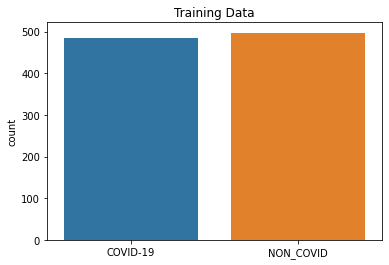

In [11]:
import seaborn as sns
sns.countplot(y_train_b, order = ['COVID-19', 'NON_COVID'])
plt.title('Training Data')

/home/amr/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Testing Data')

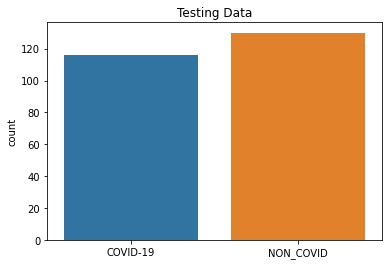

In [12]:
sns.countplot(y_test_b, order = ['COVID-19', 'NON_COVID'])
plt.title('Testing Data')

### Note:
### You can skip to the "Anvil App" section to use the app

## A. Training the algorithms using the Color Histogram features

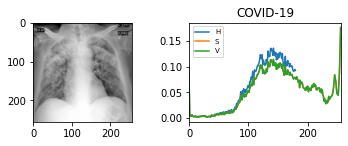

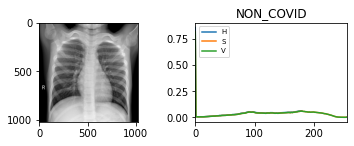

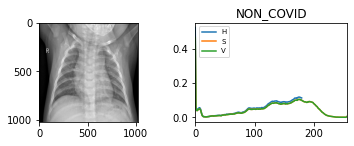

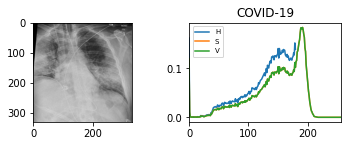

In [13]:
imagePaths = list(paths.list_images("Images-processed/"))
rand = random.choices(imagePaths, k=4)
for (i, rand) in enumerate(rand):
    img = cv2.imread(rand)
    hist_h = cv2.calcHist([img], [0], None, [180], [0, 180])
    hist_s = cv2.calcHist([img], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([img], [2], None, [256], [0, 256])
    hist_h = cv2.normalize(hist_h, hist_h)
    hist_s = cv2.normalize(hist_s, hist_s)
    hist_v = cv2.normalize(hist_v, hist_v)
    plt.subplot(221), plt.imshow(img, 'gray')
    plt.subplot(222), plt.plot(hist_h, label='H'), 
    plt.plot(hist_s, label='S'), plt.plot(hist_v, label='V'), plt.xlim(0, 256), 
    plt.legend(loc=2, prop={'size': 7})
    label = rand.split(os.path.sep)[-1].split(".")[0]
    plt.title(label)
    plt.show()

### Specify the inputs

In [14]:
X = histogram
y = labels
X_train = trainFeat
X_test = testFeat
y_train = trainLabels
y_test = testLabels

### Perform standardization by centering and scaling the training set and the test set

In [15]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

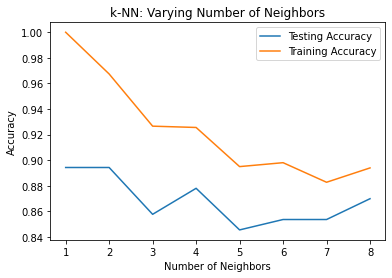

In [16]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the color histogram representations

[INFO] evaluating k-NN on color histogram accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.086s
test time:  0.576s

Train Accuracy: 0.927
Test Accuracy: 0.858


classification report:
              precision    recall  f1-score   support

    COVID-19       0.91      0.78      0.84       116
   NON_COVID       0.82      0.93      0.87       130

    accuracy                           0.86       246
   macro avg       0.87      0.85      0.86       246
weighted avg       0.86      0.86      0.86       246

confusion matrix:
[[ 90  26]
 [  9 121]]


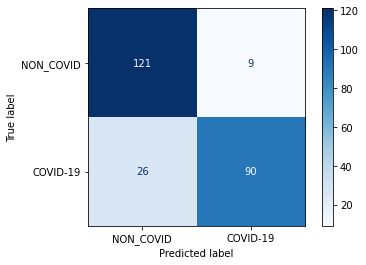

In [17]:
print("[INFO] evaluating k-NN on color histogram accuracy...")
knn = KNeighborsClassifier(n_neighbors=3) #best of odd k
results.append(benchmark(knn, 'k-NN on Color Histograms'))

### Train and evaluate a Linear SVM classifer on the color histogram representations

[INFO] evaluating Linear SVM color histogram accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 0.478s
test time:  0.043s

Train Accuracy: 0.980
Test Accuracy: 0.902

dimensionality: 692
density: 0.372832

classification report:
              precision    recall  f1-score   support

    COVID-19       0.89      0.91      0.90       116
   NON_COVID       0.91      0.90      0.91       130

    accuracy                           0.90       246
   macro avg       0.90      0.90      0.90       246
weighted avg       0.90      0.90      0.90       246

confusion matrix:
[[105  11]
 [ 13 117]]


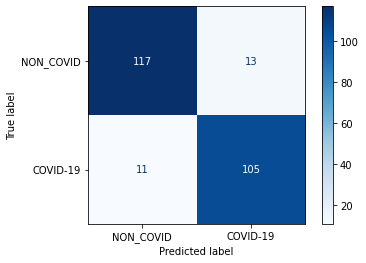

In [18]:
print("[INFO] evaluating Linear SVM color histogram accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on Color Histograms'))

### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the color histogram representations and print the classification report for the model

In [19]:
svc = svm.SVC()

# Specify the hyperparameter space
parameters = {'C':[0.1, 1, 10, 100],
              'gamma':[0.1, 1, 10, 'scale']}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(svc, parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'C': 10, 'gamma': 'scale'}


[INFO] evaluating RBF SVM on color histogram with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=10)
train time: 0.405s
test time:  0.137s

Train Accuracy: 0.993
Test Accuracy: 0.943


classification report:
              precision    recall  f1-score   support

    COVID-19       0.94      0.94      0.94       116
   NON_COVID       0.95      0.95      0.95       130

    accuracy                           0.94       246
   macro avg       0.94      0.94      0.94       246
weighted avg       0.94      0.94      0.94       246

confusion matrix:
[[109   7]
 [  7 123]]


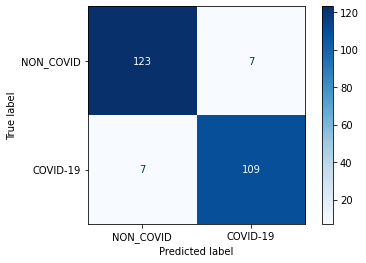

In [20]:
print("[INFO] evaluating RBF SVM on color histogram with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C=10, gamma='scale')
results.append(benchmark(rbf_svc, 'RBF SVM on Color Histograms'))

### Train and evaluate a Random Forest Classifier

[INFO] evaluating Random Forest on color histogram accuracy...
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 1.029s
test time:  0.011s

Train Accuracy: 1.000
Test Accuracy: 0.951


classification report:
              precision    recall  f1-score   support

    COVID-19       0.95      0.95      0.95       116
   NON_COVID       0.95      0.95      0.95       130

    accuracy                           0.95       246
   macro avg       0.95      0.95      0.95       246
weighted avg       0.95      0.95      0.95       246

confusion matrix:
[[110   6]
 [  6 124]]


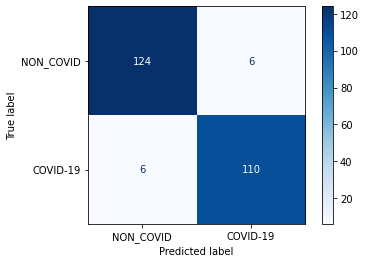

In [21]:
print("[INFO] evaluating Random Forest on color histogram accuracy...")
rfc = RandomForestClassifier()
results.append(benchmark(rfc, 'Random Forest on Color Histograms'))

### Train and evaluate a Voting Classifier with hard voting on the Color Histogram features

[INFO] evaluating Voting Classifier on color histogram accuracy...
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', SVC(kernel='linear')), ('2', SVC(C=10)),
                             ('3', RandomForestClassifier())])
train time: 1.262s
test time:  0.119s

Train Accuracy: 0.996
Test Accuracy: 0.951


classification report:
              precision    recall  f1-score   support

    COVID-19       0.94      0.96      0.95       116
   NON_COVID       0.96      0.95      0.95       130

    accuracy                           0.95       246
   macro avg       0.95      0.95      0.95       246
weighted avg       0.95      0.95      0.95       246

confusion matrix:
[[111   5]
 [  7 123]]


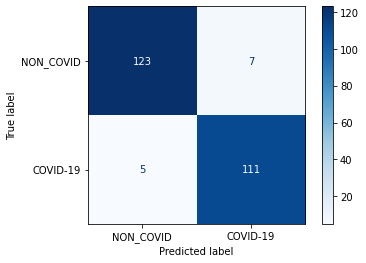

In [22]:
print("[INFO] evaluating Voting Classifier on color histogram accuracy...")
estimator = []
estimator.append(('1', linear_svc))
estimator.append(('2', rbf_svc))
estimator.append(('3', rfc))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on Color Histograms'))

## B. Training the algorithms using the Haralick Texture features

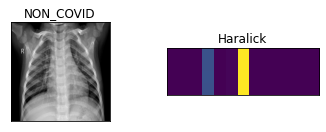

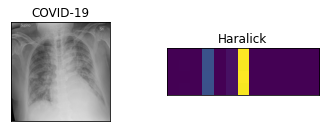

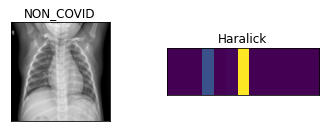

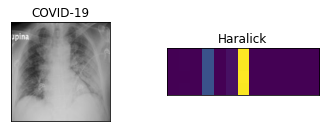

In [23]:
imagePaths = list(paths.list_images("Images-processed/"))
rand = random.choices(imagePaths, k=4)
for (i, rand) in enumerate(rand):
    img = cv2.imread(rand)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray)
    plt.subplot(2,2,1),plt.imshow(img, cmap = 'gray')
    label = rand.split(os.path.sep)[-1].split(".")[0]
    plt.title(label), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,2),plt.imshow(haralick)
    plt.title('Haralick'), plt.xticks([]), plt.yticks([])
    plt.show()

### Specify the inputs

In [24]:
X = hara
y = labels
X_train = trainHara
X_test = testHara
y_train = trainHaraL
y_test = testHaraL

### Perform standardization by centering and scaling the training set and the test set

In [25]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

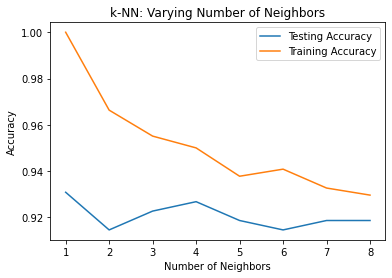

In [26]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the Haralick Texture features

[INFO] evaluating k-NN on Haralick Texture accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.003s
test time:  0.020s

Train Accuracy: 0.955
Test Accuracy: 0.923


classification report:
              precision    recall  f1-score   support

    COVID-19       0.92      0.91      0.92       116
   NON_COVID       0.92      0.93      0.93       130

    accuracy                           0.92       246
   macro avg       0.92      0.92      0.92       246
weighted avg       0.92      0.92      0.92       246

confusion matrix:
[[106  10]
 [  9 121]]


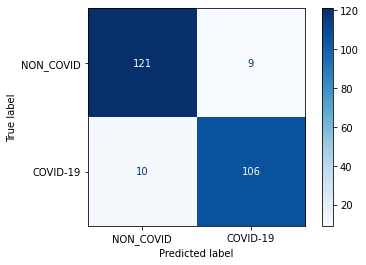

In [27]:
print("[INFO] evaluating k-NN on Haralick Texture accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
results.append(benchmark(knn, 'k-NN on Haralick Texture'))

### Train and evaluate a Linear SVM classifer on the Haralick Texture features

[INFO] evaluating Linear SVM on Haralick Texture accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 0.026s
test time:  0.002s

Train Accuracy: 0.951
Test Accuracy: 0.967

dimensionality: 13
density: 1.000000

classification report:
              precision    recall  f1-score   support

    COVID-19       0.97      0.96      0.97       116
   NON_COVID       0.96      0.98      0.97       130

    accuracy                           0.97       246
   macro avg       0.97      0.97      0.97       246
weighted avg       0.97      0.97      0.97       246

confusion matrix:
[[111   5]
 [  3 127]]


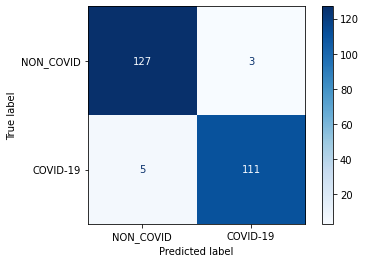

In [28]:
print("[INFO] evaluating Linear SVM on Haralick Texture accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on Haralick Texture'))

### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the Haralick Texture features and print the classification report for the model

In [29]:
svc = svm.SVC()

# Specify the hyperparameter space
parameters = {'C':[0.1, 1, 10, 100],
              'gamma':[0.1, 1, 10, 'scale']}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(svc, parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'C': 10, 'gamma': 'scale'}


[INFO] evaluating RBF SVM on Haralick Texture with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=10)
train time: 0.014s
test time:  0.002s

Train Accuracy: 0.986
Test Accuracy: 0.976


classification report:
              precision    recall  f1-score   support

    COVID-19       0.98      0.97      0.97       116
   NON_COVID       0.97      0.98      0.98       130

    accuracy                           0.98       246
   macro avg       0.98      0.98      0.98       246
weighted avg       0.98      0.98      0.98       246

confusion matrix:
[[112   4]
 [  2 128]]


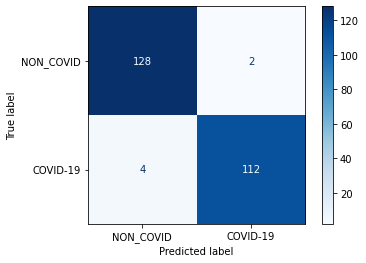

In [30]:
print("[INFO] evaluating RBF SVM on Haralick Texture with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C=10, gamma='scale')
results.append(benchmark(rbf_svc, 'RBF SVM on Haralick Texture'))

### Train and evaluate a Random Forest Classifier on the Haralick Texture representations

[INFO] evaluating Random Forest on Haralick Texture accuracy...
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 0.216s
test time:  0.010s

Train Accuracy: 1.000
Test Accuracy: 0.947


classification report:
              precision    recall  f1-score   support

    COVID-19       0.93      0.97      0.95       116
   NON_COVID       0.97      0.93      0.95       130

    accuracy                           0.95       246
   macro avg       0.95      0.95      0.95       246
weighted avg       0.95      0.95      0.95       246

confusion matrix:
[[112   4]
 [  9 121]]


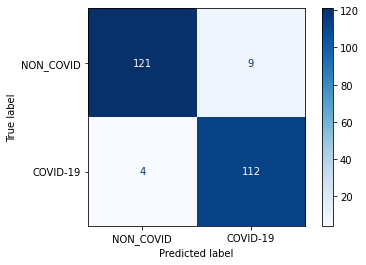

In [31]:
print("[INFO] evaluating Random Forest on Haralick Texture accuracy...")
#Train Random Forest Classifer using default parameters
rfc = RandomForestClassifier()
results.append(benchmark(rfc, 'Random Forest on Haralick Texture'))

### Train and evaluate a Voting Classifier with hard voting on the Haralick Texture representations

[INFO] evaluating Voting Classifier on Haralick Texture...
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', RandomForestClassifier()), ('2', SVC(C=10)),
                             ('3', SVC(kernel='linear'))])
train time: 0.248s
test time:  0.014s

Train Accuracy: 0.986
Test Accuracy: 0.967


classification report:
              precision    recall  f1-score   support

    COVID-19       0.97      0.96      0.97       116
   NON_COVID       0.96      0.98      0.97       130

    accuracy                           0.97       246
   macro avg       0.97      0.97      0.97       246
weighted avg       0.97      0.97      0.97       246

confusion matrix:
[[111   5]
 [  3 127]]


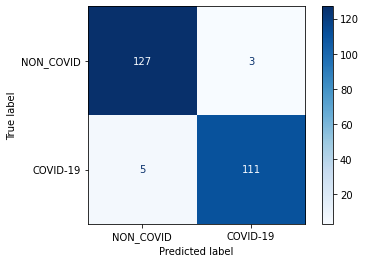

In [32]:
print("[INFO] evaluating Voting Classifier on Haralick Texture...")
start_time = time()
estimator = []
estimator.append(('1', rfc))
estimator.append(('2', rbf_svc))
estimator.append(('3', linear_svc))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on Haralick Texture'))

## C. Training the algorithms using Threshold Adjacency Statistics

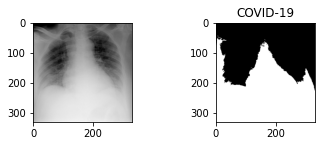

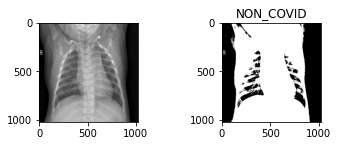

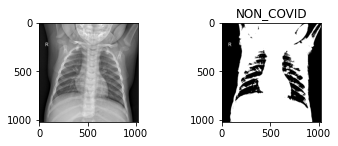

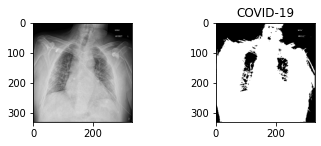

In [33]:
imagePaths = list(paths.list_images("Images-processed/"))
rand = random.choices(imagePaths, k=4)
for (i, rand) in enumerate(rand):
    img = cv2.imread(rand)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.uint8)
    T_rc = mahotas.rc(gray)
    label = rand.split(os.path.sep)[-1].split(".")[0]
    plt.subplot(221), plt.imshow(img, 'gray')
    plt.subplot(222), plt.imshow(gray > T_rc, 'gray'), plt.title(label)
    plt.show()

### Specify the inputs

In [34]:
X = tas
y = labels
X_train = trainTas
X_test = testTas
y_train = trainTasL
y_test = testTasL

### Perform standardization by centering and scaling the training set and the test set

In [35]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

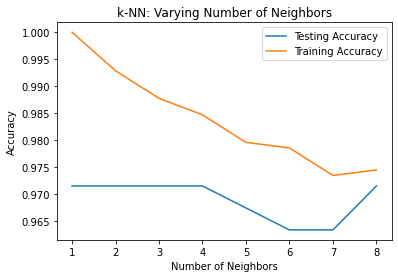

In [36]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the Threshold Adjacency Statistics (TAS)

[INFO] evaluating k-NN on TAS accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.004s
test time:  0.024s

Train Accuracy: 0.988
Test Accuracy: 0.972


classification report:
              precision    recall  f1-score   support

    COVID-19       0.98      0.96      0.97       116
   NON_COVID       0.96      0.98      0.97       130

    accuracy                           0.97       246
   macro avg       0.97      0.97      0.97       246
weighted avg       0.97      0.97      0.97       246

confusion matrix:
[[111   5]
 [  2 128]]


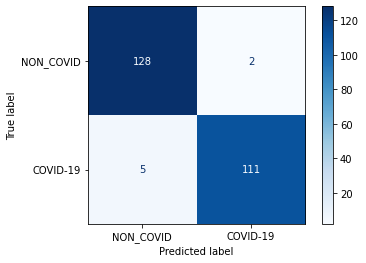

In [37]:
start_time = time()
print("[INFO] evaluating k-NN on TAS accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
results.append(benchmark(knn, 'k-NN on TAS'))

### Train and evaluate a Linear SVM classifer on the TAS representations

[INFO] evaluating Linear SVM on TAS accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 0.013s
test time:  0.001s

Train Accuracy: 0.990
Test Accuracy: 0.984

dimensionality: 54
density: 1.000000

classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.97      0.98       116
   NON_COVID       0.97      1.00      0.98       130

    accuracy                           0.98       246
   macro avg       0.99      0.98      0.98       246
weighted avg       0.98      0.98      0.98       246

confusion matrix:
[[112   4]
 [  0 130]]


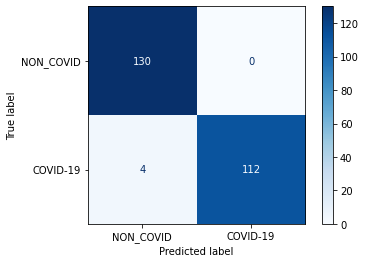

In [38]:
print("[INFO] evaluating Linear SVM on TAS accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on TAS'))

### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the TAS representations and print the classification report for the model

In [39]:
svc = svm.SVC()

# Specify the hyperparameter space
parameters = {'C':[0.1, 1, 10, 100],
              'gamma':[0.1, 1, 10,'scale']}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(svc, parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'C': 10, 'gamma': 'scale'}


[INFO] evaluating RBF SVM on TAS with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=10)
train time: 0.037s
test time:  0.007s

Train Accuracy: 0.996
Test Accuracy: 0.984


classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.97      0.98       116
   NON_COVID       0.97      1.00      0.98       130

    accuracy                           0.98       246
   macro avg       0.99      0.98      0.98       246
weighted avg       0.98      0.98      0.98       246

confusion matrix:
[[112   4]
 [  0 130]]


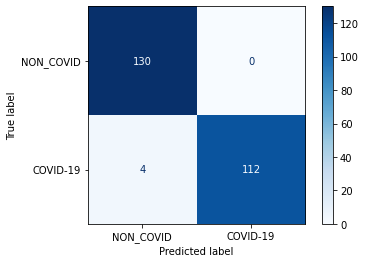

In [40]:
print("[INFO] evaluating RBF SVM on TAS with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C=10, gamma='scale')
results.append(benchmark(rbf_svc, 'RBF SVM on TAS'))

### Train and evaluate a Random Forest Classifier on the TAS representations

[INFO] evaluating Random Forest on TAS...
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 0.360s
test time:  0.009s

Train Accuracy: 1.000
Test Accuracy: 0.992


classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.98      0.99       116
   NON_COVID       0.98      1.00      0.99       130

    accuracy                           0.99       246
   macro avg       0.99      0.99      0.99       246
weighted avg       0.99      0.99      0.99       246

confusion matrix:
[[114   2]
 [  0 130]]


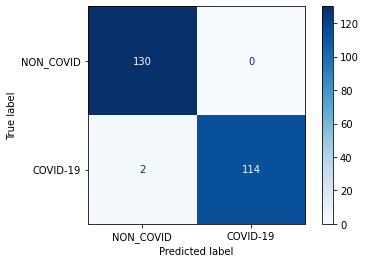

In [41]:
print("[INFO] evaluating Random Forest on TAS...")
#Train Random Forest Classifer using default parameters
rfc = RandomForestClassifier()
results.append(benchmark(rfc, 'Random Forest on TAS'))

### Train and evaluate a Voting Classifier with hard voting on the TAS representations

[INFO] evaluating Voting Classifier on TAS...
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', KNeighborsClassifier(n_neighbors=3)),
                             ('2', SVC(C=10)),
                             ('3', RandomForestClassifier())])
train time: 0.317s
test time:  0.034s

Train Accuracy: 0.997
Test Accuracy: 0.988


classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.97      0.99       116
   NON_COVID       0.98      1.00      0.99       130

    accuracy                           0.99       246
   macro avg       0.99      0.99      0.99       246
weighted avg       0.99      0.99      0.99       246

confusion matrix:
[[113   3]
 [  0 130]]


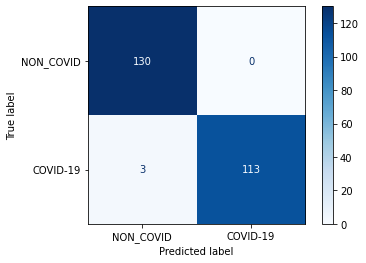

In [42]:
print("[INFO] evaluating Voting Classifier on TAS...")
start_time = time()
estimator = []
estimator.append(('1', knn))
estimator.append(('2', rbf_svc))
estimator.append(('3', rfc))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on TAS'))

## D. Training the algorithms using all features (Histograms, Haralink, & TAS)

### Specify the inputs

In [43]:
X = features
y = labels
X_train = trainF
X_test = testF
y_train = trainFL
y_test = testFL
results_feat = []

### Perform standardization by centering and scaling the training set and the test set

In [44]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

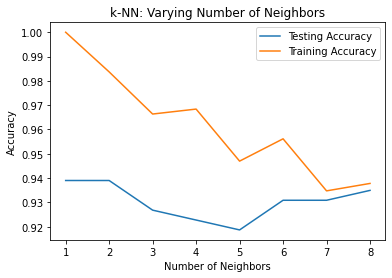

In [45]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the Features matrix

[INFO] evaluating k-NN on Features accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.051s
test time:  0.311s

Train Accuracy: 0.966
Test Accuracy: 0.927


classification report:
              precision    recall  f1-score   support

    COVID-19       0.96      0.88      0.92       116
   NON_COVID       0.90      0.97      0.93       130

    accuracy                           0.93       246
   macro avg       0.93      0.92      0.93       246
weighted avg       0.93      0.93      0.93       246

confusion matrix:
[[102  14]
 [  4 126]]


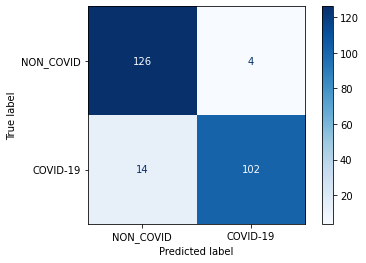

In [48]:
print("[INFO] evaluating k-NN on Features accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
results.append(benchmark(knn, 'k-NN on Features'))

### Train and evaluate a Linear SVM classifer on the Features matrix

[INFO] evaluating Linear SVM on Features accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 0.133s
test time:  0.015s

Train Accuracy: 1.000
Test Accuracy: 0.992

dimensionality: 759
density: 0.428195

classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.98      0.99       116
   NON_COVID       0.98      1.00      0.99       130

    accuracy                           0.99       246
   macro avg       0.99      0.99      0.99       246
weighted avg       0.99      0.99      0.99       246

confusion matrix:
[[114   2]
 [  0 130]]


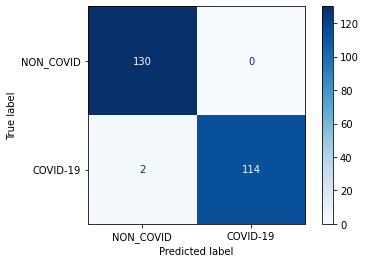

In [49]:
print("[INFO] evaluating Linear SVM on Features accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on Features'))

### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the Features matrix and print the classification report for the model

In [50]:
svc = svm.SVC()

# Specify the hyperparameter space
parameters = {'C':[0.1, 1, 10, 100],
              'gamma':[0.1, 1, 10, 'scale']}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(svc, parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'C': 10, 'gamma': 'scale'}


[INFO] evaluating RBF SVM on Features with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=10)
train time: 0.296s
test time:  0.060s

Train Accuracy: 1.000
Test Accuracy: 0.992


classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.98      0.99       116
   NON_COVID       0.98      1.00      0.99       130

    accuracy                           0.99       246
   macro avg       0.99      0.99      0.99       246
weighted avg       0.99      0.99      0.99       246

confusion matrix:
[[114   2]
 [  0 130]]


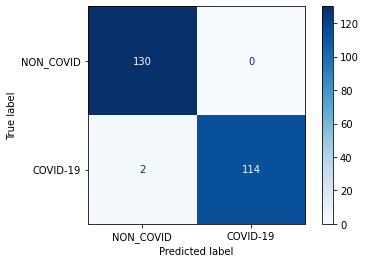

In [51]:
print("[INFO] evaluating RBF SVM on Features with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C=10, gamma='scale')
results.append(benchmark(rbf_svc, 'RBF SVM on Features'))

### Train and evaluate a Random Forest Classifier on the Features matrix

[INFO] evaluating Random Forest on Features...
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 0.442s
test time:  0.010s

Train Accuracy: 1.000
Test Accuracy: 0.988


classification report:
              precision    recall  f1-score   support

    COVID-19       0.99      0.98      0.99       116
   NON_COVID       0.98      0.99      0.99       130

    accuracy                           0.99       246
   macro avg       0.99      0.99      0.99       246
weighted avg       0.99      0.99      0.99       246

confusion matrix:
[[114   2]
 [  1 129]]


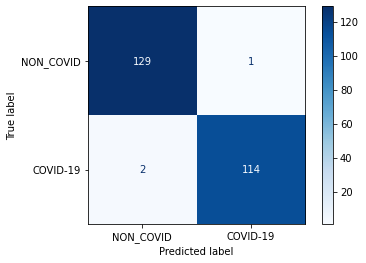

In [52]:
print("[INFO] evaluating Random Forest on Features...")
rfc = RandomForestClassifier()
results.append(benchmark(rfc, 'Random Forest on Features'))

### Train and evaluate a Voting Classifier with hard voting on the Features matrix

________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', SVC(C=10, probability=True)),
                             ('2', SVC(kernel='linear', probability=True)),
                             ('3', RandomForestClassifier())])
train time: 2.392s
test time:  0.086s

Train Accuracy: 1.000
Test Accuracy: 0.996


classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.99      1.00       116
   NON_COVID       0.99      1.00      1.00       130

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246

confusion matrix:
[[115   1]
 [  0 130]]


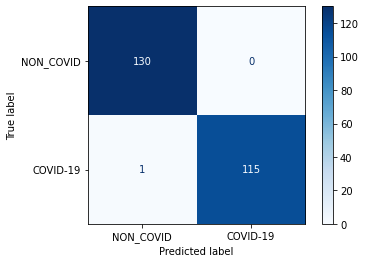

In [67]:
estimator = []
estimator.append(('1', rbf_svc))
estimator.append(('2', linear_svc))
estimator.append(('3', rfc))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on Features'))

## Benchmark

In [54]:
def scoreof(results):
    indices = np.arange(len(results))
    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results

    x = clf_names
    y = score
    x_pos = [i for i, _ in enumerate(x)]

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x_pos, y, color='b')
    plt.ylabel("Score")
    plt.title("Score")
    plt.xticks(x_pos, x)
    # Turn on the grid
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%f' % float(height),
            ha='center', va='bottom')
    autolabel(rects1)
    plt.show()

In [55]:
def timeof(results, ind):
    indices = np.arange(len(results))
    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results

    training_time = np.array(training_time)
    test_time = np.array(test_time)

    plt.figure(figsize=(15, 15))
    plt.title("Execution Time")
    plt.barh(indices + .3, training_time, .3, label="training time", color='c')
    plt.barh(indices + .6, test_time, .3, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')

    for i, c in zip(indices, clf_names):
        plt.text(ind, i, c)

    plt.show()


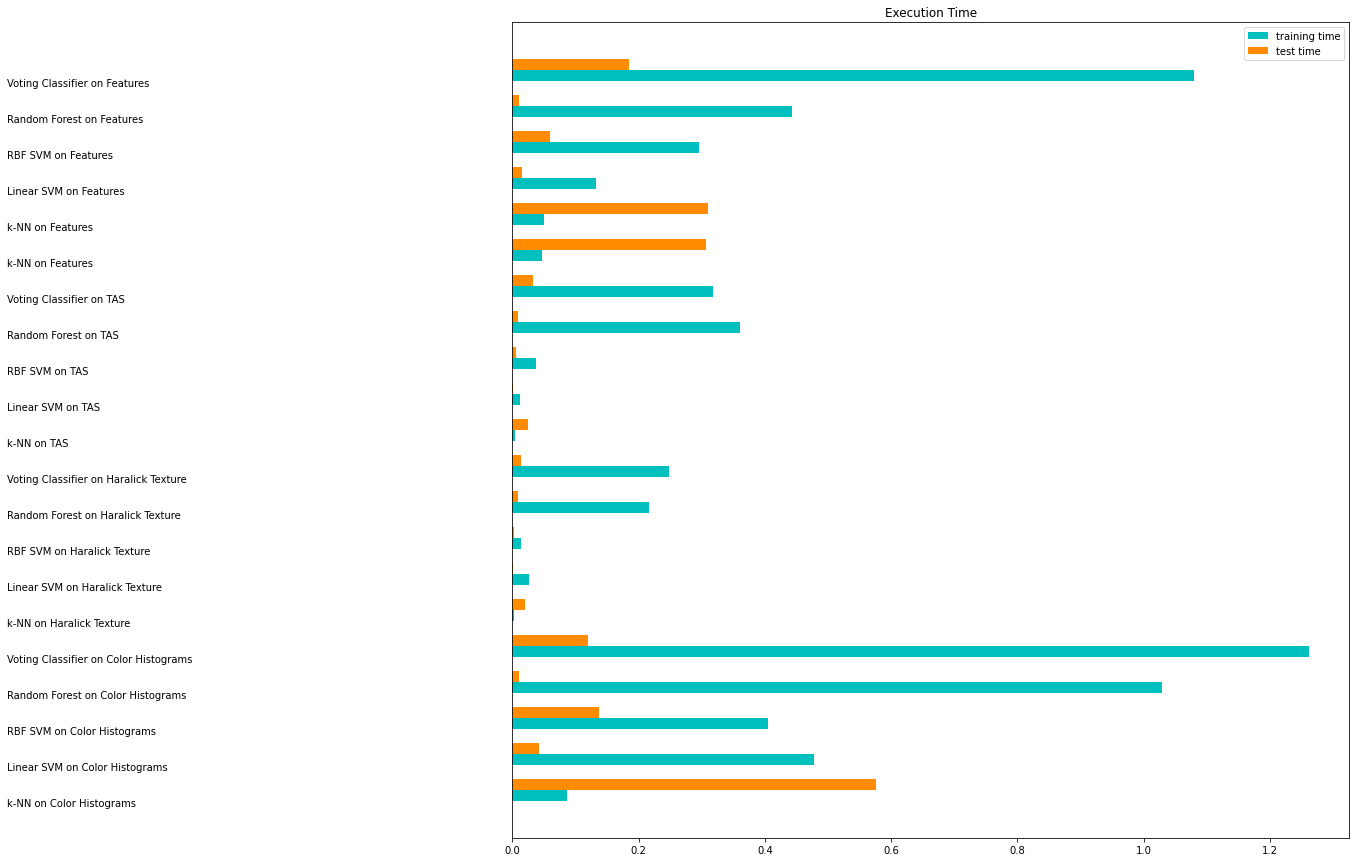

In [56]:
timeof(results, -.8)

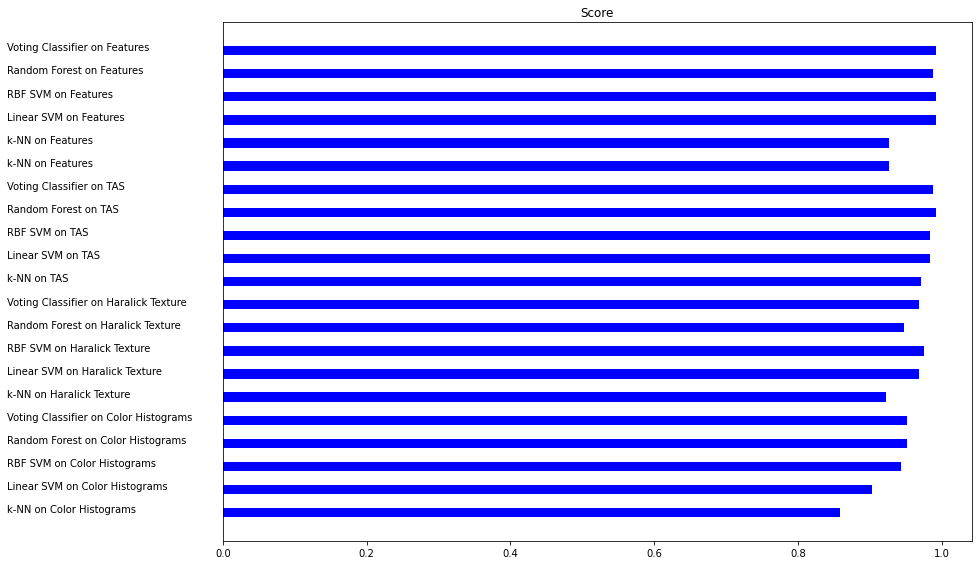

In [57]:
indices = np.arange(len(results))

clf_names, score, training_time, test_time = [[x[i] for x in results] for i in range(4)]

plt.figure(figsize=(16, 8))
plt.title("Score")
plt.barh(indices, score, .4, label="score", color='blue')
plt.yticks(())
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

### Benchmark Features

k-NN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.049s
test time:  0.301s

Train Accuracy: 0.966
Test Accuracy: 0.927


classification report:
              precision    recall  f1-score   support

    COVID-19       0.96      0.88      0.92       116
   NON_COVID       0.90      0.97      0.93       130

    accuracy                           0.93       246
   macro avg       0.93      0.92      0.93       246
weighted avg       0.93      0.93      0.93       246

confusion matrix:
[[102  14]
 [  4 126]]


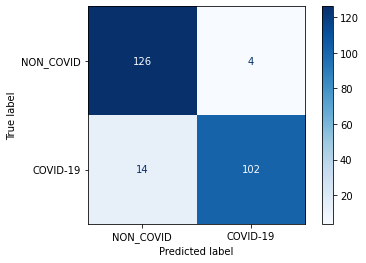


Linear SVM
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 0.124s
test time:  0.015s

Train Accuracy: 1.000
Test Accuracy: 0.992

dimensionality: 759
density: 0.428195

classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.98      0.99       116
   NON_COVID       0.98      1.00      0.99       130

    accuracy                           0.99       246
   macro avg       0.99      0.99      0.99       246
weighted avg       0.99      0.99      0.99       246

confusion matrix:
[[114   2]
 [  0 130]]


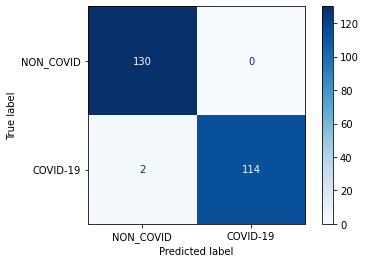


RBF SVM
________________________________________________________________________________
Training: 
SVC(C=10)
train time: 0.287s
test time:  0.060s

Train Accuracy: 1.000
Test Accuracy: 0.992


classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.98      0.99       116
   NON_COVID       0.98      1.00      0.99       130

    accuracy                           0.99       246
   macro avg       0.99      0.99      0.99       246
weighted avg       0.99      0.99      0.99       246

confusion matrix:
[[114   2]
 [  0 130]]


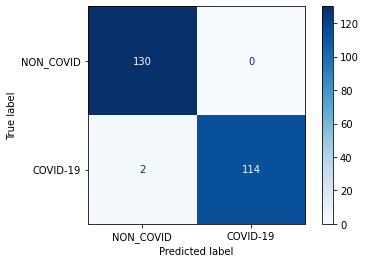


Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 0.875s
test time:  0.021s

Train Accuracy: 1.000
Test Accuracy: 0.988


classification report:
              precision    recall  f1-score   support

    COVID-19       0.98      0.99      0.99       116
   NON_COVID       0.99      0.98      0.99       130

    accuracy                           0.99       246
   macro avg       0.99      0.99      0.99       246
weighted avg       0.99      0.99      0.99       246

confusion matrix:
[[115   1]
 [  2 128]]


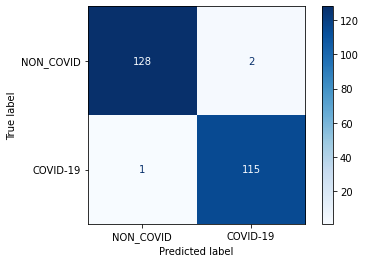


Voting Classifier
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', SVC(C=10)), ('2', SVC(kernel='linear')),
                             ('3', RandomForestClassifier())])
train time: 1.417s
test time:  0.087s

Train Accuracy: 1.000
Test Accuracy: 0.996


classification report:
              precision    recall  f1-score   support

    COVID-19       1.00      0.99      1.00       116
   NON_COVID       0.99      1.00      1.00       130

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246

confusion matrix:
[[115   1]
 [  0 130]]


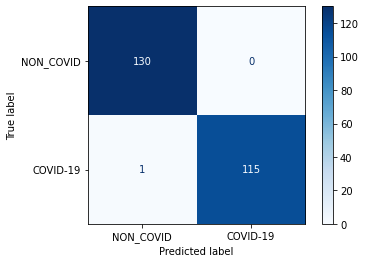

In [58]:
results_feat = []
for clf, name in (
        (knn, "k-NN"),
        (linear_svc, "Linear SVM"),
        (rbf_svc, "RBF SVM"),
        (rfc, "Random Forest"),
        (vot_hard, "Voting Classifier")):
    print('=' * 80)
    print(name)
    results_feat.append(benchmark(clf, name))


print('=' * 80)


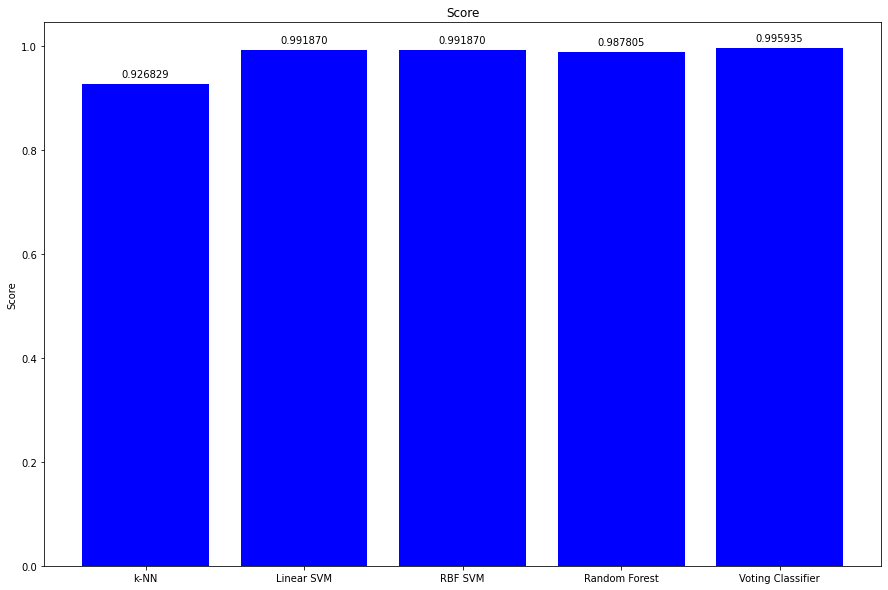

In [59]:
scoreof(results_feat)

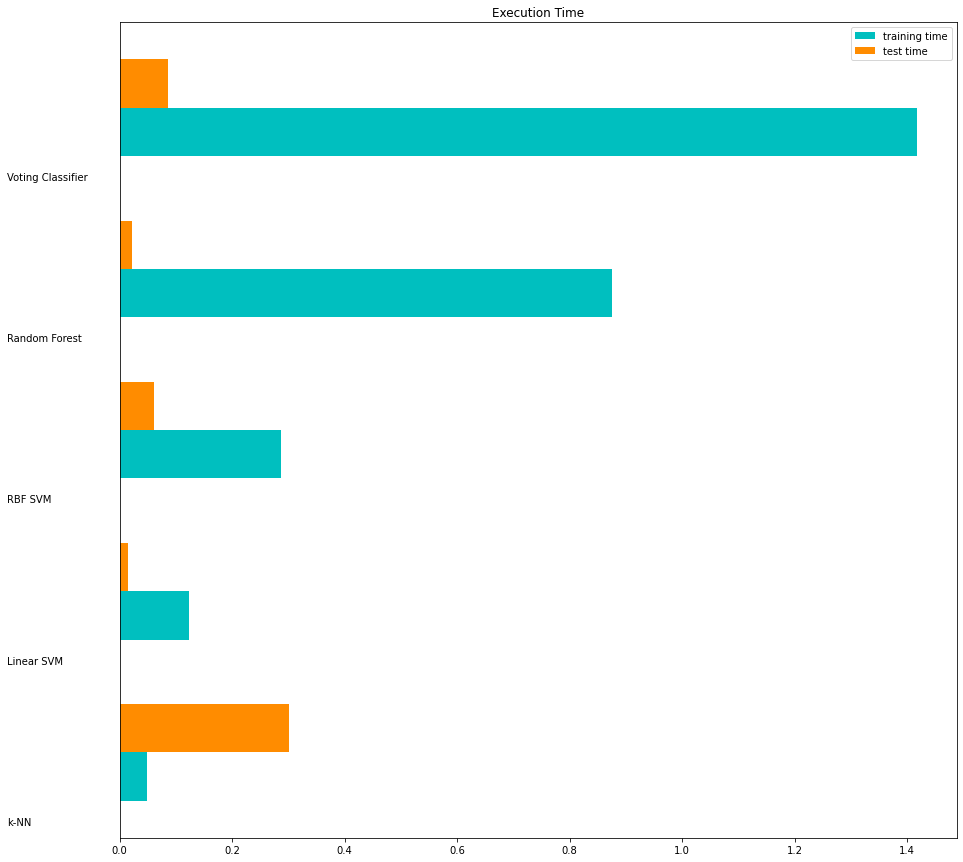

In [60]:
timeof(results_feat, -0.2)

## Further method

### Train and evaluate a Multi-layer Perceptron classifier on the Features matrix

[INFO] evaluating MLPClassifier on Features...
________________________________________________________________________________
Training: 
MLPClassifier(hidden_layer_sizes=500)
train time: 4.964s
test time:  0.007s

Train Accuracy: 1.000
Test Accuracy: 0.992


classification report:
              precision    recall  f1-score   support

    COVID-19       0.99      0.99      0.99       116
   NON_COVID       0.99      0.99      0.99       130

    accuracy                           0.99       246
   macro avg       0.99      0.99      0.99       246
weighted avg       0.99      0.99      0.99       246

confusion matrix:
[[115   1]
 [  1 129]]


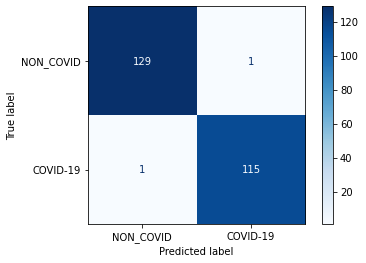

In [61]:
from sklearn.neural_network import MLPClassifier
print("[INFO] evaluating MLPClassifier on Features...")
start_time = time()
mlp = MLPClassifier(hidden_layer_sizes=500)
results_feat.append(benchmark(mlp,'MLPClassifier'))

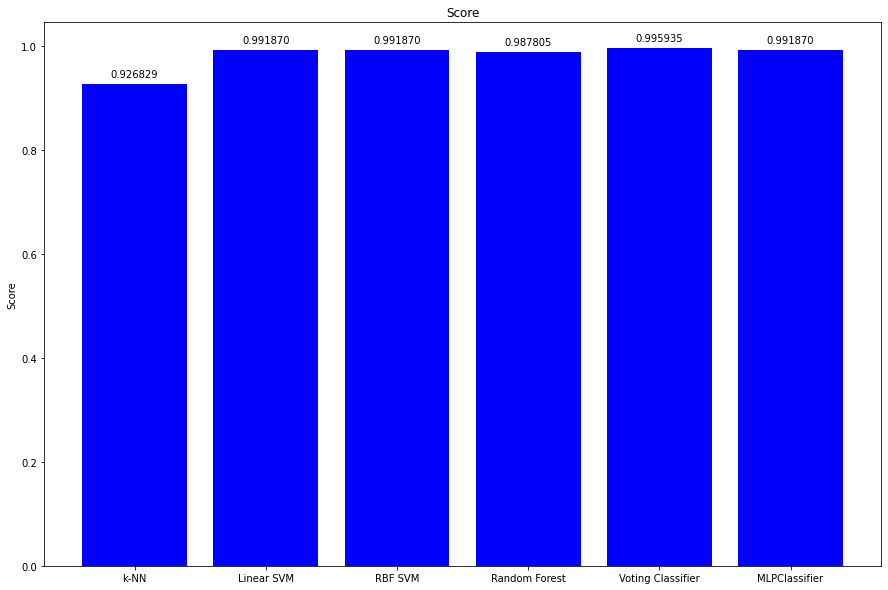

In [62]:
scoreof(results_feat)

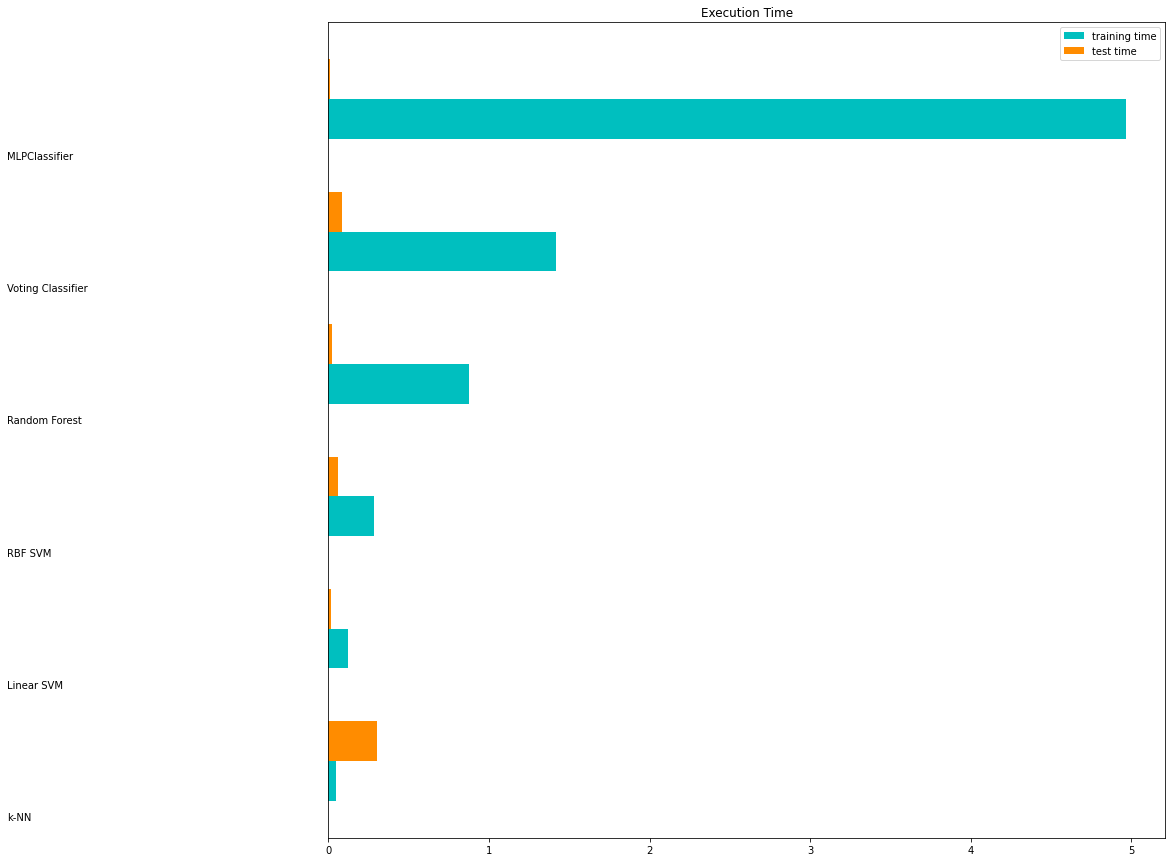

In [63]:
timeof(results_feat, -2)

## Anvil App

In [64]:
print("[INFO] Building Anvil app...")
t0 = time()
X = features
y = labels
X_train = trainF
X_test = testF
y_train = trainFL
y_test = testFL
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)
linear_svc = svm.SVC(kernel='linear', probability=True)
linear_svc.fit(X_train, y_train)
rbf_svc = svm.SVC(kernel='rbf', C = 10, gamma = 'scale', probability=True)
rbf_svc.fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
mlp = MLPClassifier(hidden_layer_sizes=500)
mlp.fit(X_train, y_train)
estimator = []
estimator.append(('1', rfc))
estimator.append(('2', linear_svc))
estimator.append(('3', rbf_svc))
nLinearSVC = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, y_train)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

[INFO] Building Anvil app...
train time: 9.527s


In [65]:
import anvil.server
anvil.server.connect("3YPAFQMZCK7HF3I4K2LTMRLD-XLRLG4JQYH74F4SS")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


In [ ]:
import anvil.media

@anvil.server.callable
def classify_image(file):
    with anvil.media.TempFile(file) as filename:
        img = cv2.imread(filename)
    histogram_imp = []
    hara_imp = []
    tas_imp = []
    labels_imp = []
    features_imp = []

    histogram_imp.append(extract_color_histogram(img))
    tas_imp.append(fd_tas(img))
    hara_imp.append(fd_haralick(img))

    histogram_imp = np.array(histogram_imp)
    hara_imp = np.array(hara_imp)
    tas_imp = np.array(tas_imp)
    features_imp = np.concatenate((hara_imp, tas_imp), axis=1)
    features_imp = np.concatenate((features_imp, histogram_imp), axis=1)

    X_pred = features_imp
    X_pred = sc.transform(X_pred)

    return('k-NN Probability of COVID-19: {:.2f}%'.format(knn.predict_proba(X_pred)[0][0]*100) +
            '\nSVM Probability of COVID-19: {:.2f}%'.format(rbf_svc.predict_proba(X_pred)[0][0]*100) +
            '\nLinearSVC Probability of COVID-19: {:.2f}%'.format(linear_svc.predict_proba(X_pred)[0][0]*100) +
            '\nRandom Forest Probability of COVID-19: {:.2f}%'.format(rfc.predict_proba(X_pred)[0][0]*100) +
            '\nMLP Probability of COVID-19: {:.2f}%'.format(mlp.predict_proba(X_pred)[0][0]*100) +
            '\nVoting Classifier of LinearSVC, SVM, & RF with Hard Voting Result: {}'.format(vot_hard.predict(X_pred)[0]))

anvil.server.wait_forever()

### Now go to https://XLRLG4JQYH74F4SS.anvil.app/VMNA2YYY6MBAPGAFDPMDIOIW and upload an X-ray image. For optimum results used a cropped image that looks like this

In [ ]:
anvil.server.disconnect()